# definition

In [ ]:
'''
    Example script for hit-based background trackign study with awkward arrays and podio module
    please run this within eic-shell if you want to use any podio modules:
        in eic-shell, type jupyer-lab to start the server (may take a minute)--> copy the localhost link to your browser or editor to open the notebook.

    key functions: get_traj_hits, get_part_hits
    
    It uses uproot (>2.7), seaborn, particle, and a few other python modules. You may need to pip install them. 

    Shujie Li, Oct 2025
'''
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.max_rows = 200
pd.options.display.min_rows = 20
pd.options.display.max_columns = 100

import awkward as ak
import uproot as ur
# import podio
# from podio import root_io

import sys
import os
import time
from collections import defaultdict
from fnmatch import fnmatch
import types
from particle import Particle

import seaborn as sns
sns.set_theme(
    style='whitegrid',#'white',#'coolwarm',
    context='notebook',#'talk', 
    palette='bright',#'viridis',
    font_scale=1.,
    rc={'figure.figsize': (6, 4)}
)
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xaxis.labellocation'] = 'right'
plt.rcParams['yaxis.labellocation'] = 'top'
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title]


## mcparticle generator status: xxx1=primary undecayed, xxx2=primary decayed
status_to_source = {
    1: "DIS", 2: "DIS",
    2001: "SR", 2002: "SR", 
    3001: "Bremstrahlung", 3002: "Bremstrahlung",
    4001: "Coulomb", 4002: "Coulomb",
    5001: "Touschek", 5002: "Touschek",
    6001: "Proton beam gas", 6002: "Proton beam gas"
}

## track quality cuts
TRACK_HIT_COUNT_MIN_MIN   = 3 ## absolute min to form a track with CKF
TRACK_HIT_COUNT_MIN       = 4
TRACK_MOM_MIN             = 0.3
TRACK_PT_MIN              = 0.2
TRACK_HIT_FRACTION_MIN    = 0.5
TRACK_HIT_COUNT_GHOST_MAX = 2
VERTEX_CUT_R_MAX          = 2
VERTEX_CUT_Z_MAX          = 200#mm

# Detector geometry definitions (as of epic 25.08)
barrel_range = [(30,42),(46,60),(115,130),(265,280),(415,450),(540,600),(610,650),(700,750)]
barrel_name = ["L0","L1","L2","L3","L4","inner MPGD","TOF","outer MPGD"]
name_sim_barrel = ["VertexBarrelHits","VertexBarrelHits","VertexBarrelHits","SiBarrelHits","SiBarrelHits","MPGDBarrelHits","TOFBarrelHits","OuterMPGDBarrelHits"]
name_rec_barrel = ["SiBarrelVertexRecHits","SiBarrelVertexRecHits","SiBarrelVertexRecHits","SiBarrelTrackerRecHits","SiBarrelTrackerRecHits","MPGDBarrelRecHits","TOFBarrelRecHits","OuterMPGDBarrelRecHits"]

disk_range = [(-1210.0, -1190.0), (-1110.0, -1090.0),(-104.0, -100.0), (-860.0, -840.0),
 (-660.0, -640.0), (-460.0, -440.0), (-260.0, -240.0), (240.0, 260.0),
 (440.0, 460.0), (690.0, 710.0), (990.0, 1010.0), (1340.0, 1360.0),
 (1480.0, 1500.0), (1600.0, 1620.0), (1840.0, 1860.0), (1865.0, 1885.0)]
disk_name = ["E-MPGD Disk2","E-MPGD Disk 1","E-Si Disk 5","E-Si Disk 4","E-Si Disk 3","E-Si Disk 2","E-Si Disk 1",
                "H-Si Disk 1","H-Si Disk 2","H-Si Disk 3","H-Si Disk 4","H-Si Disk 5","H-MPGD Disk 1","H-MPGD Disk 2", "H-TOF Disk1","H-TOF Disk2"]
name_rec_disk = ["BackwardMPGDEndcapRecHits","BackwardMPGDEndcapRecHits",
               "SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits","SiEndcapTrackerRecHits",
               "ForwardMPGDEndcapRecHits","ForwardMPGDEndcapRecHits",
               "TOFEndcapRecHits","TOFEndcapRecHits"]
name_sim_disk = ["BackwardMPGDEndcapHits","BackwardMPGDEndcapHits",
               "TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","TrackerEndcapHits","ForwardMPGDEndcapHits","ForwardMPGDEndcapHits",
               "TOFEndcapHits","TOFEndcapHits"]

# Global variables for caching
COL_TABLE = {}
CACHED_DATA = {}

def ak_flat(ak_array):
    return ak.to_numpy(ak.flatten(ak_array,axis=0))

def ak_df(ak_array):
    return ak.to_dataframe(ak_array)

def ak_hist(ak_array, **kwargs):
    return plt.hist(ak_flat(ak_array), **kwargs)

def ak_filter(br, cond, field=None):
    filtered = br[cond]
    return filtered[field] if field else filtered

def ak_sns(ak_array, **kwargs):
    # Check if it's 2D (tuple/list of two arrays)
    if isinstance(ak_array, (tuple, list)) and len(ak_array) == 2:
        x_data = ak_flat(ak_array[0])
        y_data = ak_flat(ak_array[1])
        # Remove 1D-specific kwargs for 2D plots
        kwargs.pop('element', None)
        kwargs.pop('fill', None)
        return sns.histplot(x=x_data, y=y_data, **kwargs)
    else:
        # 1D histogram
        return sns.histplot(ak_flat(ak_array), element="step", fill=False, **kwargs)


def get_pdg_info(PDG):
    """Get particle info from PDG code"""
    try:
        return Particle.from_pdgid(PDG)
    except Exception:
        if PDG == 9902210:
            return Particle.from_pdgid(2212)
        print(f"ERROR (get_pdg_info): unknown PDG ID {PDG}")
        return Particle.empty()


def theta2eta(xx, inverse=0):
    """Convert theta to eta or vice versa"""
    if type(xx)==list:
        xx = np.array(xx)
    if inverse==1:
        return np.arctan((np.e)**(-xx))*2
    else:
        return -np.log(np.tan(xx/2.))

def select_string(strings, patterns):
    """Select strings matching patterns with wildcards"""
    if not isinstance(patterns, list):
        raise ValueError("The 'patterns' argument must be a list.")
    
    patterns = [pattern.lower() for pattern in patterns]
    return [s for s in strings if any(fnmatch(s.lower(), pattern) for pattern in patterns)]


def read_ur(fname, tname, s3_dir=""):
    """Read ROOT file with uproot"""
    server = 'root://dtn-eic.jlab.org//volatile/eic/'
    if len(s3_dir) > 1:
        fname = server + s3_dir + fname
    tree = ur.open(fname)[tname]
    print(f"read_ur: read {fname}:{tname}. {tree.num_entries} events in total")
    return tree

def get_col_table(fname, s3_dir="", verb=0):
    """Get collection table from metadata"""
    global COL_TABLE
    meta = read_ur(fname, "podio_metadata", s3_dir)
    if "events___idTable" in meta.keys(): ## < eic-shell 25.09
        col_name = np.array(meta["m_names"].array()[0])
        col_id = np.array(meta["m_collectionIDs"].array()[0])
    else:
        col_id = get_branch_df(meta,"events___CollectionTypeInfo/events___CollectionTypeInfo.collectionID")["values"].tolist()
        col_name = get_branch_df(meta,"events___CollectionTypeInfo/events___CollectionTypeInfo.name")["values"].tolist()

    COL_TABLE = {}
    for ii, nn in zip(col_id, col_name):
        if verb:
            print(ii, nn)
        COL_TABLE[ii] = nn
    return COL_TABLE


# ============= BRANCH READING with ak or df =============

def get_branch_ak(tree, bname="", entry_start=0, entry_stop=-1, 
                           fields_subset=None, chunk_size=1000, verb=0):
    """Optimized branch reading with awkward arrays"""
    if bname not in tree.keys():
        sys.exit(f"ERROR(get_branch_ak): can't find branch {bname}")
    if verb:    
        print(f"Reading branch: {bname}")
    start_time = time.time()
    
    # Determine actual entry range
    if entry_stop == -1:
        entry_stop = tree.num_entries
    
    total_entries = entry_stop - entry_start
    if verb:
        print(f"Reading {total_entries} entries")
    
    # For large datasets, read in chunks
    if total_entries > chunk_size:
        if verb:
            print(f"Using chunked reading with chunk_size={chunk_size}")
        all_data = []
        
        for chunk_start in range(entry_start, entry_stop, chunk_size):
            chunk_end = min(chunk_start + chunk_size, entry_stop)
            if verb:
                print(f"  Reading chunk: {chunk_start} to {chunk_end}")
            
            chunk_data = tree[bname].array(
                library="ak",
                entry_start=chunk_start,
                entry_stop=chunk_end
            )
            all_data.append(chunk_data)
        
        # Concatenate all chunks
        ak_data = ak.concatenate(all_data)
    else:
        # Read all at once for smaller datasets
        ak_data = tree[bname].array(
            library="ak",
            entry_start=entry_start,
            entry_stop=entry_stop
        )
    
    read_time = time.time()
    if verb:
        print(f"Awkward read: {read_time - start_time:.2f}s ({ak_data.nbytes/1e6:.1f} MB)")
    
    # Rename fields by dropping branch prefix
    if hasattr(ak_data, 'fields'):
        if not ak_data.fields:
            ## return a single array
            return ak_data
        renamed_fields = {}
        for field in ak_data.fields:
            if "[" in field: ## drop nested array such as CentralCKFTrackParameters.covariance.covariance[21]
                continue
            if field.startswith(f'{bname}.'):
                new_name = field.replace(f'{bname}.', '')
                renamed_fields[new_name] = ak_data[field]
            else:
                renamed_fields[field] = ak_data[field]
        
        ak_data = ak.zip(renamed_fields)
        if verb:
            print(f"Renamed {len(renamed_fields)} fields")
    
    # Extract subset of fields if specified
    if fields_subset and hasattr(ak_data, 'fields'):
        subset_data = {}
        for field in fields_subset:
            if field in ak_data.fields:
                subset_data[field] = ak_data[field]
        ak_data = ak.zip(subset_data)
        if verb:
            print(f"Extracted subset: {fields_subset}")
    
    total_time = time.time()
    if verb:
            print(f"Total time: {total_time - start_time:.2f}s")
    
    return ak_data

def get_branch_df(tree, bname="", entry_start=0, entry_stop=-1, 
                           fields_subset=None, chunk_size=1000, verb=0):
    """Get branch as DataFrame when needed (for compatibility)"""
    ak_data = get_branch_ak(tree, bname, entry_start, entry_stop, 
                                     fields_subset, chunk_size)
    
    if verb:
        print("Converting to DataFrame...")
    start_time = time.time()
    
    try:
        df = ak.to_dataframe(ak_data)
        df = df.reset_index()  # Flatten the multi-index
        
        convert_time = time.time() - start_time
        if verb:
            print(f"DataFrame conversion: {convert_time:.2f}s")
            print(f"DataFrame shape: {df.shape}")
        
        return df
    
    except Exception as e:
        print(f"DataFrame conversion failed: {e}")
        print("Returning awkward array instead")
        return ak_data

def get_part(tree, entry_start=0, entry_stop=-1, chunk_size=1000, kprimary=1):
    """MC particles reading, return ak with calculated eta, momentum etc"""
    # print("Reading MC particles as akward arrays...")
    
    # Read as awkward array
    ak_data = get_branch_ak(tree, "MCParticles", entry_start, entry_stop, 
                                     chunk_size=chunk_size)
    if kprimary:
        print("Select all primary particles with generatorStatus==x001 or x002")
        ak_data=ak_data[(ak_data.generatorStatus%1000==1)|(ak_data.generatorStatus%1000==2)]
    # Compute momentum quantities vectorized
    px = ak_data["momentum.x"]
    py = ak_data["momentum.y"]
    pz = ak_data["momentum.z"]
    
    p_mag = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p_mag)
    phi = np.arctan2(py, px)
    eta = -np.log(np.tan(theta / 2.0))
    pt = p_mag * np.sin(theta)
    
    # Compute vertex quantities
    vx = ak_data["vertex.x"]
    vy = ak_data["vertex.y"]
    vz = ak_data["vertex.z"]
    vertex_r = np.sqrt(vx**2 + vy**2)
    vertex_dist = np.sqrt(vertex_r**2 + vz**2)
    
    # Compute endpoint quantities  
    ex = ak_data["endpoint.x"]
    ey = ak_data["endpoint.y"]
    endpoint_r = np.sqrt(ex**2 + ey**2)
    
    # Get PDG names (this is slower, so we do it efficiently)
    pdg_codes = ak.to_numpy(ak.flatten(ak_data.PDG))
    unique_pdgs = np.unique(pdg_codes)
    
    # Create PDG name mapping for unique values only
    pdg_name_map = {}
    for pdg in unique_pdgs:
        pdg_name_map[pdg] = get_pdg_info(pdg).name
    
    # Apply mapping vectorized
    pdg_names = ak.unflatten(
        np.array([pdg_name_map[pdg] for pdg in pdg_codes]),
        ak.num(ak_data.PDG)
    )
    
    # Create new awkward array with selected quantities
    my_field=['PDG', 'generatorStatus',  'charge', 'time', 'mass',
       'vertex.x', 'vertex.y', 'vertex.z', 'endpoint.x', 'endpoint.y',
       'endpoint.z', 'momentum.x', 'momentum.y', 'momentum.z']
    enhanced_data = ak.zip({
        # Original fields
        **{field: ak_data[field] for field in my_field},
        # Derived quantities
        'mom': p_mag,
        'theta': theta,
        'phi': phi,
        'eta': eta,
        'pt': pt,
        'vertex_r': vertex_r,
        'vertex_dist': vertex_dist,
        'endpoint_r': endpoint_r,
        'pdg_name': pdg_names
    })
    
    return enhanced_data

def get_params(tree, bname="CentralCKFTrackParameters", entry_start=0, entry_stop=-1, chunk_size=1000):
    """Track Parameters reading, return ak with calculated eta, mom, pt"""
    
    # Read as awkward array
    ak_data = get_branch_ak(tree, bname, entry_start, entry_stop, 
                                     chunk_size=chunk_size)
    ak_data["eta"]  = theta2eta(ak_data.theta)
    ak_data["mom"]  = abs(1./ak_data.qOverP)
    ak_data["pt"]  = abs(ak_data.mom*np.sin(ak_data.theta))
    return ak_data


## podio-based relation handling
*  run this within eic-shell to get podio plugin.

In [2]:
def read_podio(fname, tname="events",s3_dir=""):
    """Read ROOT file with podio. Does NOT work for the metadata tree """
    # from podio import root_io
    import sys
    if 'podio' not in sys.modules:
        print("Loading podio ROOT IO reader(this will take ~2 minutes)...")

    from podio.root_io import Reader  # More specific
    
    server = 'root://dtn-eic.jlab.org//volatile/eic/'
    if len(s3_dir) > 1:
        fname = server + s3_dir + fname
    reader = Reader(fname)
    tree = reader.get("events")
    print(f"read_podio: read {fname}:{tname}. {len(tree)} events in total")
    return tree  

def show_getter_podio(collection):
    """Display basic info about collection or single object"""
    type_check = check_type(collection)
    
    if type_check.is_iterable:
        print(f"Number of objects: {len(collection)}")
        sample_obj = collection[0] if len(collection) > 0 else None
    else:
        print("Single object")
        sample_obj = collection
    
    if sample_obj:
        sample_type = type(sample_obj).__name__
        print(f"Object type: {sample_type}")
        getters = [m for m in dir(sample_obj) if m.startswith('get') and not m.startswith('_')]
        print(f"Available getter methods ({len(getters)}):")
        for getter in getters:
            print(f"  {getter}")

        # Pretty print version
        scalars = {m: getattr(sample_obj, m)() for m in dir(sample_obj) 
                if m.startswith('get') and not m.startswith('_') and callable(getattr(sample_obj, m)) 
                and isinstance(getattr(sample_obj, m)(), (int, float, bool, str))}
        for k, v in scalars.items(): print(f"{k}: {v}")

import fnmatch
def show_collections_podio(event, pattern=None):
    """Show collections matching pattern (case-insensitive), or all if no pattern"""
    all_collections = event.getAvailableCollections()
    if pattern:
        collections = [name for name in all_collections 
                      if fnmatch.fnmatch(name.lower(), pattern.lower())]
    else:
        collections = all_collections
    # print(f"Collections ({len(collections)}):")
    # for name in collections:
    #     print(f"  {name}") 
    return collections

def get_collection_member_podio(podio_collection, member_name):
    """
    Access podio object members in uproot/awkward style
    
    Args:
        podio_collection: The podio branch (collection or single object)
        member_name: Member name (like "nHoles", "chi2")
    """
    type_check = check_type(podio_collection)
    if type_check.is_empty:
        raise ValueError("Collection is empty")
    
    # Helper function to process a single object
    def process_single_object(obj):
        # Common getter patterns in podio
        possible_getters = [
            f"get{member_name}",
            f"get{member_name.capitalize()}",
            f"getN{member_name.capitalize()}",  # for count-like members
            member_name
        ]
        
        for getter_name in possible_getters:
            if hasattr(obj, getter_name):
                attr = getattr(obj, getter_name)
                if callable(attr):
                    return attr()
                else:
                    return attr
        
        # If not found, show available members
        all_methods = [method for method in dir(obj) if not method.startswith('_')]
        getters = [method for method in all_methods if method.startswith('get')]
        other_attrs = [attr for attr in all_methods if not attr.startswith('get') and not callable(getattr(obj, attr, None))]
        
        error_msg = f"Cannot find member '{member_name}' in {type(obj).__name__}\n"
        error_msg += f"Available getter methods:\n"
        for getter in getters:
            error_msg += f"  {getter}\n"
        if other_attrs:
            error_msg += f"Available attributes:\n"
            for attr in other_attrs:
                error_msg += f"  {attr}\n"
        
        raise AttributeError(error_msg)
    
    if type_check.is_iterable:
        # Process collection - return list of results
        results = []
        for obj in podio_collection:
            results.append(process_single_object(obj))
        return results
    else: 
        # Process single object - return single result
        return process_single_object(podio_collection)

class PodioCollectionWrapper:
    def __init__(self, podio_collection):
        self.collection = podio_collection
        self.type_check = check_type(podio_collection)
    
    def __getitem__(self, member_name):
        return get_collection_member_podio(self.collection, member_name)
    
    def __len__(self):
        return len(self.collection) if self.type_check.is_iterable else 1
    
    def __iter__(self):
        return iter(self.collection) if self.type_check.is_iterable else iter([self.collection])

def check_type(obj):
    """Check object type with comprehensive categorization"""    
    def get_value_category(value):
        # Check for numbers first
        if isinstance(value, (int, float, complex, bool)):
            return 'number'
        # Check for numpy arrays
        elif isinstance(value, np.ndarray):
            if value.ndim == 1:
                return 'array'
            else:
                return 'nested_array'  # 2D, 3D arrays etc.
        # Check for Python lists/tuples
        elif isinstance(value, (list, tuple)):
            if len(value) > 0:
                # Check if it's a list of arrays (nested structure)
                first_item = value[0]
                if isinstance(first_item, (np.ndarray, list, tuple)):
                    return 'nested_array'
                else:
                    return 'list'
            else:
                return 'list'
        # Check for podio RelationRange or other iterable collections
        elif 'RelationRange' in str(type(value)) or (hasattr(value, '__len__') and hasattr(value, '__iter__') and not isinstance(value, str)):
            return 'range'
        # Everything else is an object
        else:
            return 'object'

    # Create a simple container
    class CategoryValue:
        def __init__(self, val):
            self.value = val
            cat = get_value_category(val)
            self.category = cat
            self.size        = getattr(val, '__len__', lambda: 1)()
            self.is_empty    = getattr(val, '__len__', lambda: 1)() == 0

            self.is_range  = (cat == "range")
            self.is_number = (cat == "number") 
            self.is_object = (cat == "object")
            self.is_array  = (cat == "array")
            self.is_nested_array = (cat == "nested_array")
            self.is_list   = (cat == "list")
            # Convenience groupings
            self.is_iterable = cat in ["range", "array", "nested_array", "list"]
            self.is_numpy    = cat in ["array", "nested_array"]
            self.is_simple   = cat in ["number", "list", "array"]
            
    return CategoryValue(obj)


def build_rawhit_lookup(obj_list):
    """Build fast lookup using cellID + time + charge as unique key"""
    return {(obj.getCellID(), obj.getTimeStamp(), obj.getCharge()): i 
            for i, obj in enumerate(obj_list)}

def get_rawhit_index(lookup,obj):
    key = (obj.getCellID(), obj.getTimeStamp(), obj.getCharge())
    return lookup.get(key, -1)

def build_obj_lookup(obj_list):
    """Build lookup that handles multiple objects with same collectionID+index"""
    lookup = {}
    for i, obj in enumerate(obj_list):
        key = (obj.id().collectionID, obj.id().index)
        if key not in lookup:
            lookup[key] = []
        lookup[key].append(i)
    return lookup

def get_obj_indices(lookup, obj):
    """Return list of all indices matching the object's key"""
    key = (obj.id().collectionID, obj.id().index)
    return lookup.get(key, [])

def get_traj_hits(event,bname="CentralCKFTrajectories",kcombine=0):
    ## ALL raw (one) --> sim hit (many, with weight) associations for a given event. Noise hits won't have association.
    ## ----------------
    # traj-based info
    ## ----------------
    ## keep track of the rawhit(simhit) index in the association, which includes all central tracker hits in one collection.
    asso=event.get("CentralTrackingRawHitAssociations") 
    asso_raw=PodioCollectionWrapper(asso)["RawHit"]
    lookup = build_obj_lookup(asso_raw)
    br    = event.get(bname) ## for one event, can have multiple subentries
    vname = "Measurements_deprecated"
    ltraj=[]
    lhit=[]
    lweight=[]
    # lpos =[]
    lpart=[]
    lrec_hit_col=[]
    lrec_hit_id=[]
    ## for each traj--> each measurement --> rec hit --> raw hit --> match raw with sim by association index --> particle
    for ii,traj in enumerate(br):
        measurements  = PodioCollectionWrapper(traj)[vname]
        rec_hits = PodioCollectionWrapper(measurements)["Hits"]
        for hits in rec_hits:
            hit = hits[0] ## one meas to one rec hit for now
            rec_col=hit.id().collectionID
            rec_id =hit.id().index
            # pos = hit.getPosition()
            raw  = hit.getRawHit() #rec2raw is one2one
            indx = get_obj_indices(lookup, raw) ## get raw hit indices in asso (one raw could occur multiple times with different sim)
            if len(indx)==0: ## not included in association means this is a noise hit
                print("this is a noise hits")
                lhit.append(-1)
                lpart.append(-1)
                # lweight.append(0)
                ltraj.append(ii)
                lrec_hit_col.append(rec_col)
                lrec_hit_id.append(rec_id)
                # lpos.append([pos.x,pos.y,pos.z])
            else:
                for ind in indx:
                    sim  = asso[ind].getSimHit()
                    ltraj.append(ii)
                    lhit.append(ind) 
                    # lweight.append(asso[ind].getWeight())
                    part = sim.getMCParticle()
                    lpart.append(part.id().index)
                    lrec_hit_col.append(rec_col)
                    lrec_hit_id.append(rec_id)
                    # lpos.append([pos.x,pos.y,pos.z])
    traj_hits=pd.DataFrame({"traj_id":ltraj,  "part_id":lpart, "asso_hit":lhit, "rec_hit_col": lrec_hit_col, "rec_hit_id": lrec_hit_id}) 
    #"position":lpos, "hit_weight":lweight})

    ## check for overlapped tracks (for now ambiguity solver config won't allow sharing hits)
    reoccur_hit=traj_hits.groupby('asso_hit').filter(lambda group: len(group) > 1)
    for row in reoccur_hit.itertuples():
        print(f'WARNING: duplihits detected:', row)

    ## if one rec hit is associated to multiple sim hits, but all sim hits go to the same particle, then only keep one entry. 
    ## FIXME: not sure if this will work if we allow overlap traj hit. 
    traj_hits = traj_hits.drop_duplicates(subset=["part_id", "traj_id","rec_hit_col", "rec_hit_id"],  keep="first")
    traj_hits['weight'] = (traj_hits.groupby(['traj_id', 'part_id']).transform('size') / 
                        traj_hits.groupby('traj_id').transform('size'))

    if kcombine:
        traj_hits = traj_hits.groupby(['traj_id', 'part_id'], as_index=False).agg({
            'asso_hit': list,
            'weight': 'first'  # Keep the weight value (should be same for same traj+particle)
        })

    return traj_hits

def get_part_hits(event, traj_hits):
    ## ----------------
    # particle-based info
    ## ----------------
    ltraj_id=[]
    lpart_id=[]
    lsimhit=[]
    lgenID=[]
    lraw_hit_col=[]
    lraw_hit_id=[]
    # lpart=[]
    # lposition=[]

    ## for fast lookup (instead of traj_hits.asso_hit==ii). Assume no shared hits
    traj_dict = traj_hits.set_index('asso_hit').to_dict('index')
    ## for each simhit (that is converted to rec hit-->measurement candidate), find related particle and traj
    asso=event.get("CentralTrackingRawHitAssociations")
    for ii,association in enumerate(asso):
        sim  = association.getSimHit()
        part = sim.getMCParticle()
        # cond_vertex   =  (np.sqrt(part.getVertex().x**2+part.getVertex().y**2)<1 )&(abs(part.getVertex().z)<100)
        # cond = cond_vertex
        cond=True
        if cond:
            lsimhit.append(ii) ## as before, use unique index (and unique sim hit) from the association. 
            # lpart.append(part)
            lpart_id.append(part.id().index)
            lgenID.append(part.getGeneratorStatus())
            raw  = association.getRawHit()
            lraw_hit_col.append(raw.id().collectionID)
            lraw_hit_id.append(raw.id().index)
            # lposition.append(sim.getPosition())

            ## find which trajectory used this hit
            if ii in traj_dict:
                ltraj_id.append(traj_dict[ii]["traj_id"])
            else:
                ltraj_id.append(-1)
    part_hits = pd.DataFrame({"part_id":lpart_id, "part_status":lgenID, "asso_hit":lsimhit, "traj_id":ltraj_id, 
                            "raw_hit_col": lraw_hit_col, "raw_hit_id": lraw_hit_id})#, "position":lposition, "particle": lpart})
    part_hits = part_hits.drop_duplicates(subset=["part_id", "traj_id", "raw_hit_col", "raw_hit_id"],  keep="first")

    # df = primary_hits[primary_hits.groupby('particle')['particle'].transform('count') >= 3]
    return part_hits

def get_traj_purity(traj_hits):
    '''
    traj_hits is the output from get_target_traj_hits()
    returns trajectory and source, max fraction=purity
    '''
    grouped = traj_hits.groupby(['traj_id'])
    # Analyze each group
    result = grouped['part_id'].agg([
        ('total_count', 'count'),
        ('unique_source', lambda x: x.nunique()),
        ('most_common_source', lambda x: x.value_counts().idxmax()),
        ('max_count', lambda x: x.value_counts().max())
    ])

    # Calculate derived columns
    result['max_fraction'] = result['max_count'] / result['total_count']
    # result['all_same'] = result['unique_source'] == 1
    return result.copy().reset_index()


def plot_part_traj_flow(df, params=None, mcpart=None):
    """Create alluvial-style diagram showing particle-trajectory flows"""
    # dict_part = dict(zip(df["part_id"], df["particle"]))

    # Separate used and unused hits
    df_used = df[df['traj_id'] != -1]  # Only hits used in trajectories
    df_all = df  # All hits including unused
    
    # Calculate statistics
    particle_totals = df_all.groupby('part_id')['asso_hit'].apply(len)    # Total hits per particle
    particle_used   = df_used.groupby('part_id')['asso_hit'].apply(len)   # Used hits per particle
    traj_totals     = df_used.groupby('traj_id')['asso_hit'].apply(len)   # Total hits per trajectory
    
    # Only include particles that have some used hits (have flows)
    particles_with_flows = df_used['part_id'].unique()
    trajectories = sorted(df_used['traj_id'].unique())  # Only trajectories with used hits
    len1 = len(particles_with_flows)
    len2 = len(trajectories)
    # Prepare flow data (only for used hits)
    flows = df_used.groupby(['part_id', 'traj_id'])['asso_hit'].apply(len).reset_index()
    flows.columns = ['part_id', 'traj_id', 'hits']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Position particles on left, trajectories on right
    particle_y = {p: i for i, p in enumerate(sorted(particles_with_flows))}
    traj_y     = {t: i for i, t in enumerate(trajectories)}
    
    # Draw flows as curved lines
    for _, row in flows.iterrows():
        particle = row['part_id']
        traj     = row['traj_id']
        hits     = row['hits']
        
        # Start and end points
        x1, y1 = 0, len1 - particle_y[particle]
        x2, y2 = 1, len1 - traj_y[traj]
        
        # Create curved line
        x_curve = [x1, 0.5, x2]
        y_curve = [y1, (y1 + y2) / 2, y2]
        
        # Line thickness proportional to hits
        linewidth = max(1, hits / flows['hits'].max() * 10)
        
        ax.plot(x_curve, y_curve, linewidth=linewidth, alpha=0.6)
    
    # Add particle labels (only for particles with flows)
    ax.text(-0.25, len1+1,  f'Particle ID:  (used/total hits)',  ha='left', va='center')
    ax.text(0.9,   len1+1,  f'Trajectory ID: (nMeasurements)',  ha='left', va='center')

    for i, p in enumerate(sorted(particles_with_flows)):
        total_hits = particle_totals[p]
        used_hits = particle_used[p]
        color = 'k'
        if total_hits<TRACK_HIT_COUNT_MIN:
            color="grey"
        if mcpart is not None:
            pp=mcpart.iloc[int(p)]
            if abs(pp["vertex_r"])>VERTEX_CUT_R_MAX or abs(pp["vertex.z"])>VERTEX_CUT_Z_MAX or pp["mom"]<TRACK_MOM_MIN:
                color='grey'
            ax.text(-0.03, len1-i,  f'#{p}: {status_to_source[pp.generatorStatus]} ({used_hits}/{total_hits})',
                ha='right', va='center',color=color)
        else:
            ax.text(-0.03, len1-i,  f'#{p}:   ({used_hits}/{total_hits})',
                ha='right', va='center',color=color)
            
    # Add trajectory labels
    for i, t in enumerate(trajectories):
        total_traj_hits = traj_totals[t]
        color="k"
        if total_traj_hits<TRACK_HIT_COUNT_MIN:
            color="grey"
        if params is not None: 
            p = params.iloc[int(t)]
            if abs(p["loc.a"])>VERTEX_CUT_R_MAX or abs(p["loc.b"])>VERTEX_CUT_Z_MAX or p["mom"]<TRACK_MOM_MIN:
                color='grey'
                # print(t, ["loc.a"], p["loc.b"])
        ax.text(1.03, len1-i, f'#{int(t)} ({total_traj_hits})', 
                ha='left', va='center', color=color)
    
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.5, max(len(particles_with_flows), len(trajectories)) +3)
    ax.set_title('Particle to Trajectory Flow (Particles with Used Hits Only)')
    ax.axis('off')
    
    return plt


def get_part_traj_counts(event,mcpart, kverbose=0):
    traj_hits=get_traj_hits(event)
    part_hits=get_part_hits(event,traj_hits)
    # mcpart=ak.to_dataframe(get_part(tree,entry_start=iev,entry_stop=iev+1, kprimary=0)).reset_index()
    # params=ak.to_dataframe(get_params(tree,"CentralCKFTrackParameters",entry_start=iev,entry_stop=iev+1))

    ## -----------Find good track-----------
    ## Get counts per (traj_id, part_id) and total per traj_id
    traj_counts = get_traj_purity(traj_hits)
    ## get generator status
    traj_counts["part_status"]=traj_counts["most_common_source"].apply(lambda x: mcpart.iloc[x].generatorStatus)

    ## -----------Find good particles-----------
    ## track hit cut
    part_counts = part_hits.groupby("part_id").size()
    part_counts = part_counts[part_counts>=TRACK_HIT_COUNT_MIN_MIN]
    mcpart_hits = mcpart.iloc[part_counts.index].copy()
    mcpart_hits["hit_counts"] = part_counts.values
    traj_counts["part_status"]=traj_counts["most_common_source"].apply(lambda x: mcpart.iloc[x].generatorStatus)
    ## only do event-by-event quality check when required. Otherwise return the dataframe for further analysis
    if kverbose:
        good_part_id   = (part_hits.groupby("part_id").size()>=TRACK_HIT_COUNT_MIN)
        part_hits_good = part_hits[part_hits["part_id"].isin(good_part_id[good_part_id].index)][["part_id","part_status"]].drop_duplicates()
        good_mcpart    = mcpart.iloc[part_hits_good.part_id.unique()]
        ## vertex and momentum cut
        cond_vertex = (abs(good_mcpart.vertex_r)<VERTEX_CUT_R_MAX)&(abs(good_mcpart["vertex.z"])<VERTEX_CUT_Z_MAX)
        cond_mom    = (good_mcpart.mom>TRACK_MOM_MIN)
        good_mcpart = good_mcpart[cond_vertex&cond_mom]
        ## signal or background
        cond_sig    = (good_mcpart.generatorStatus==1)|(good_mcpart.generatorStatus==2)
        good_mcpart_sig  =good_mcpart[cond_sig]
        good_mcpart_other=good_mcpart[(~cond_sig)]
        print("Number of good particles (signal, other):",len(good_mcpart_sig), len(good_mcpart_other))


    if kverbose:
        traj_counts["traj_status"]=0
        traj_counts.loc[(traj_counts.max_fraction<TRACK_HIT_FRACTION_MIN) | (traj_counts.max_count<=TRACK_HIT_COUNT_GHOST_MAX),"traj_status"]=-1 ## ghost status=-1
        traj_counts.loc[(traj_counts.traj_status>-1)&(traj_counts['total_count']>=TRACK_HIT_COUNT_MIN),'traj_status']=1

        ghost_traj_id = traj_counts[traj_counts.traj_status==-1].index.tolist()
        print("list of ghost track id:", ghost_traj_id)
        good_traj=traj_counts[traj_counts.traj_status==1].copy()
        good_traj_sig=good_traj[(good_traj.part_status==1)|(good_traj.part_status==2)]
        ntraj_sig   = len(good_traj_sig)
        ntraj_other = len(good_traj)-ntraj_sig
        print("Number of good tracks from sig/others:",ntraj_sig, ntraj_other)
    ## hit purity for good tracks
    ## Percentage of track hits from a single source 
        purity_hit=good_traj.max_fraction.to_list()
        print("Hit purity:" , purity_hit)
    ##-----------Track to particle efficiency----------------
    # fraction of good signal particles that are linked to some good track
        good_part_sig_id = good_mcpart_sig.index.get_level_values('subentry').tolist()
        good_traj_id = good_traj.most_common_source.unique()
        good_traj_sig_id = good_traj_sig.most_common_source.unique()
        common = list(set(good_part_sig_id) & set(good_traj_id))
        print(set(good_part_sig_id),  set(good_traj_sig_id), common)
        ## 50% of the total particle hits go to that traj <---- skip this for now for a looser check
        # good_traj['fract'] = good_traj['max_count'] / good_traj['most_common_source'].map(part_hits['part_id'].value_counts())
        # good_traj=good_traj.fract>=0.5
    return mcpart_hits, traj_counts



# hit-based analysis with podio

In [ ]:
## load rootfile
## NOTE: MAC users sometimes experience issue with xrootd and can not directly access the official simulation files on JLab server with uproot. In this case, please first follow instructions at https://eic.github.io/epic-prod/documentation/faq.html to download rootfiles to your local computer with xrdcp. 

# example background file available on JLab ifarm: 
# /lustre24/expphy/volatile/halla/triton/shujie/rec_bgmerged_forced_18x275_n1000.root

dir_path  = ''
fname     = 'rec_bgmerged_forced_18x275_n1000.root'
tree_pd = read_podio(fname,dir_path)
tree=read_ur(fname,"events",dir_path)
## get branch name and collection ID
COL_TABLE=get_col_table(fname,dir_path)


In [ ]:
part=ak.to_dataframe(get_part(tree, entry_start=0, entry_stop=-1, chunk_size=1000)) 

varname = "eta"
bins = np.arange(-15, 10, 0.2)

# Filter for charged particles
# partc = ak_filter(part, part.charge != 0)
partc=part
# Create conditions for different generator statuses
cond_dis = (partc.generatorStatus == 1) | (partc.generatorStatus == 2)
cond_sr = (partc.generatorStatus == 2001) | (partc.generatorStatus == 2002)
cond_brem = (partc.generatorStatus == 3001) | (partc.generatorStatus == 3002)
cond_coulomb = (partc.generatorStatus == 4001) | (partc.generatorStatus == 4002)
cond_touschek = (partc.generatorStatus == 5001) | (partc.generatorStatus == 5002)
cond_proton = (partc.generatorStatus == 6001) | (partc.generatorStatus == 6002)

# Plot histograms using your ak_hist helper function
_ = ak_hist(ak_filter(partc, cond_dis, varname), bins=bins, label="1, 2:DIS", color="grey", histtype="step")
_ = ak_hist(ak_filter(partc, cond_sr, varname), bins=bins, label="200x:SR", histtype="step", alpha=1)
_ = ak_hist(ak_filter(partc, cond_brem, varname), bins=bins, label="300x:Bremstrahlung", histtype="step", alpha=1)
_ = ak_hist(ak_filter(partc, cond_coulomb, varname), bins=bins, label="400x:Coulomb", histtype="step", alpha=1)
_ = ak_hist(ak_filter(partc, cond_touschek, varname), bins=bins, label="500x:Touschek", histtype="step", alpha=1)
_ = ak_hist(ak_filter(partc, cond_proton, varname), bins=bins, label="600x:Proton beam gas", histtype="step", alpha=1)

plt.legend(title="MCParticles.generatorStatus",title_fontsize=10,fontsize=10)
plt.title("Primary Particles")
plt.yscale('log')
plt.xlabel(f"$\eta$")

#### check track to particle relation for one event

<module 'matplotlib.pylab' from '/opt/local/lib/python3.12/site-packages/matplotlib/pylab.py'>

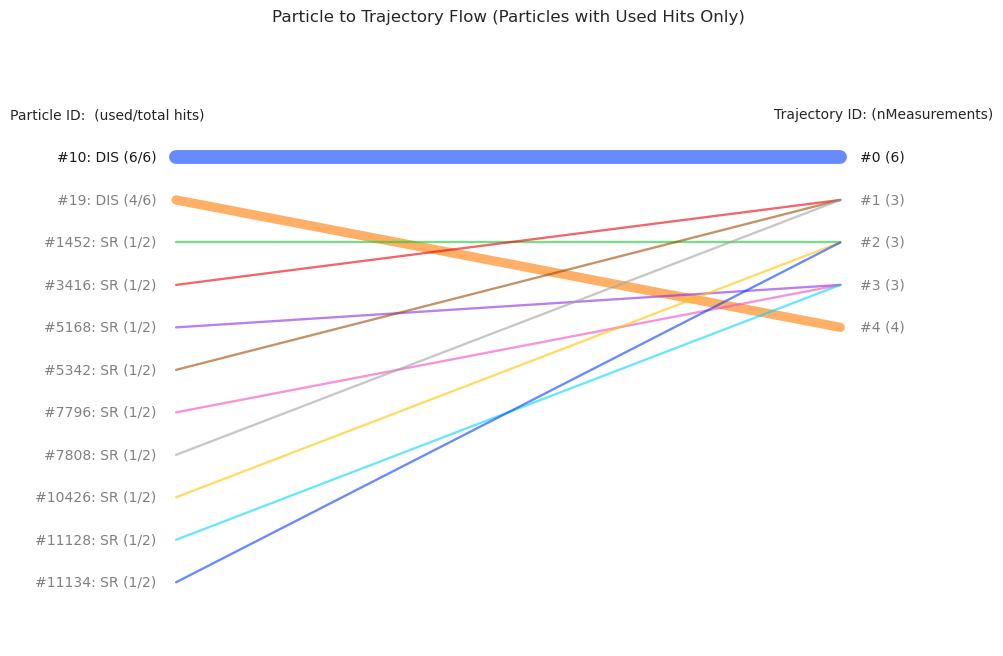

In [19]:

## get one event
iev   = 4
event = tree_pd[iev]
parts = event.get("MCParticles")

traj_name="CentralCKFTrajectories"
para_name="CentralCKFTrackParameters"
mcpart=ak.to_dataframe(get_part(tree,entry_start=iev,entry_stop=iev+1, kprimary=0))
params=ak.to_dataframe(get_params(tree,para_name,entry_start=iev,entry_stop=iev+1))
tracks=ak.to_dataframe(get_branch_ak(tree,traj_name,entry_start=iev,entry_stop=iev+1))

traj_hits=get_traj_hits(event,bname=traj_name)
part_hits=get_part_hits(event,traj_hits)
plot_part_traj_flow(part_hits,params,mcpart)


#### plot hit positions for one event/track/particle


In [ ]:
df=get_branch_df(tree,"_CentralTrackerMeasurements_hits")
[print(COL_TABLE[nn]) for nn in df.collectionID.unique()]


SiBarrelTrackerRecHits
SiBarrelVertexRecHits
SiEndcapTrackerRecHits
TOFBarrelRecHits
TOFEndcapRecHits
MPGDBarrelRecHits
BackwardMPGDEndcapRecHits
ForwardMPGDEndcapRecHits
OuterMPGDBarrelRecHits


[None, None, None, None, None, None, None, None, None]

In [ ]:
iev   = 20
mcpart=ak.to_dataframe(get_part(tree,entry_start=iev,entry_stop=iev+1, kprimary=0))
params=ak.to_dataframe(get_params(tree,"CentralCKFTrackParameters",entry_start=iev,entry_stop=iev+1))
tracks=ak.to_dataframe(get_branch_ak(tree,"CentralCKFTrajectories",entry_start=iev,entry_stop=iev+1))

event = tree_pd[iev]
asso  = event.get("CentralTrackingRawHitAssociations")
trajs = event.get("CentralCKFTrajectories")

## get all hits for one event.
all_rechits=event.get("CentralTrackingRecHits")
all_pos=PodioCollectionWrapper(all_rechits)["Position"]
xpos, ypos, zpos = np.array([[pp.x, pp.y, pp.z] for pp in all_pos]).T
rpos = np.sqrt(xpos**2+ypos**2)






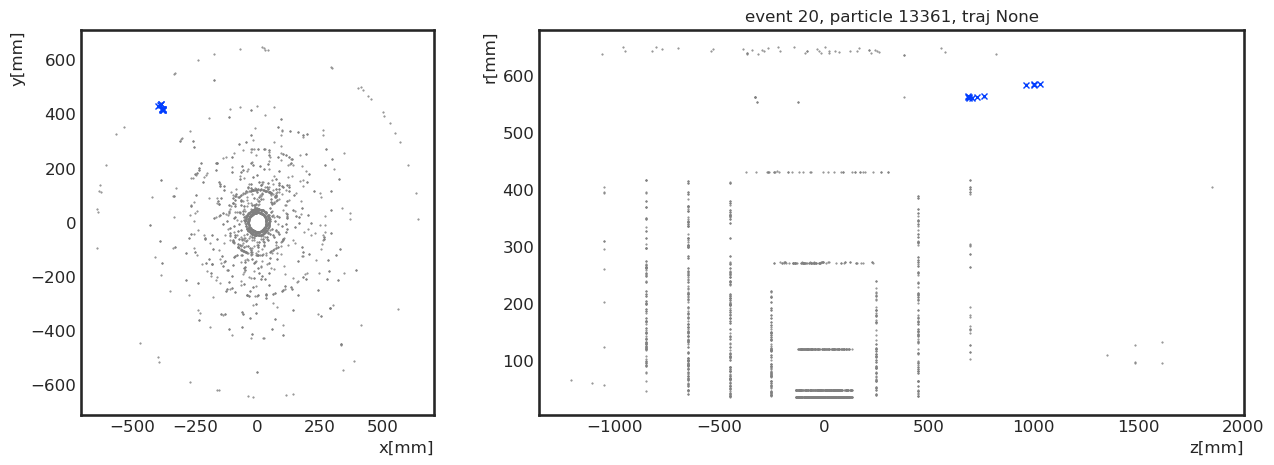

In [ ]:
## plot desired particle and track

ipart = 13361
itraj = None

## two subplot for x-y, and z-r
fig, axes = plt.subplots(1, 2, figsize=(15, 5),gridspec_kw={'width_ratios': [1, 2]})
# for ax in axes:
    # ax.set_aspect('equal') 
ms = 4

def get_asso_pos(asso, id_list):
    lpos=[]
    for asso_id in id_list:
        simhit = asso[asso_id].getSimHit()
        pos=simhit.getPosition()
        lpos.append([pos.x, pos.y, pos.z])
    return np.array(lpos).T

if ipart is not None: 
    hit_part=part_hits[part_hits.part_id==ipart].asso_hit.tolist()
    x1,y1,z1=get_asso_pos(asso,hit_part)

    axes[0].plot(xpos,ypos,ms=1,ls="none",marker='.',c="grey")
    axes[0].plot(x1,y1,ms=4,ls="none",marker="x")

    axes[1].plot(zpos,rpos,ms=1,ls="none",marker='.',c="grey")
    axes[1].plot(z1,np.sqrt(y1**2+x1**2),ms=ms,ls="none",marker="x")

ms = 5
if itraj is not None: 
    color='r'
    traj = trajs[itraj]
    def plot_pos(l_hits,l_chi2, koutlier=0):
        mfc=color
        if koutlier:
            mfc='none'
        for ii,mm in enumerate(l_hits):
            pos=mm.getHits()[0].getPosition()
            r  = np.sqrt(pos.x**2+pos.y**2)
            axes[0].plot(pos.x, pos.y,ms=ms,ls="none",marker="o", mfc=mfc, color=color)
            axes[1].plot(pos.z, r    ,ms=ms,ls="none",marker="o", mfc=mfc, color=color)
            axes[1].text(pos.z+10, r    ,f"{l_chi2[ii]:.3f}")

    l_chi2=traj.getMeasurementChi2()
    l_hits=traj.getMeasurements_deprecated()
    plot_pos(l_hits,l_chi2)
    l_chi2=traj.getOutlierChi2()
    l_hits=traj.getOutliers_deprecated()
    plot_pos(l_hits,l_chi2, 1)
    

axes[0].set_xlabel("x[mm]")
axes[0].set_ylabel("y[mm]")
axes[1].set_xlabel("z[mm]")
axes[1].set_ylabel("r[mm]")
plt.title(f"event {iev}, particle {ipart}, traj {itraj}")
plt.savefig(f"/global/cfs/cdirs/m3763/shujie/worksim/plots/hit_pos_ev{iev}_part{ipart}_traj{itraj}.png")


#### check track quality with N events


In [12]:
## load rootfile
fname = "/global/cfs/cdirs/m3763/shujie/worksim/background/rec_bgmerged_forced_18x275_n1000.root"
tree_pd = read_podio(fname)
tree=read_ur(fname,"events")
COL_TABLE=get_col_table(fname)

read_podio: read /global/cfs/cdirs/m3763/shujie/worksim/background/rec_bgmerged_forced_18x275_n1000.root:events. 1000 events in total
read_ur: read /global/cfs/cdirs/m3763/shujie/worksim/background/rec_bgmerged_forced_18x275_n1000.root:events. 1000 events in total
read_ur: read /global/cfs/cdirs/m3763/shujie/worksim/background/rec_bgmerged_forced_18x275_n1000.root:podio_metadata. 1 events in total


In [46]:
# TRACK_HIT_COUNT_MIN       = 4
# TRACK_MOM_MIN             = 0.3
# TRACK_PT_MIN              = 0.2
# TRACK_HIT_FRACTION_MIN    = 0.5
# TRACK_HIT_COUNT_GHOST_MAX = 2
# VERTEX_CUT_R_MAX          = 2
# VERTEX_CUT_Z_MAX          = 200#mm

track_hit_count_min      = 4 #TRACK_HIT_COUNT_MIN         
track_mom_min            = 0.3 #TRACK_MOM_MIN              
track_pt_min             = TRACK_PT_MIN                  
track_hit_fraction_min   = TRACK_HIT_FRACTION_MIN          
track_hit_count_ghost_max= TRACK_HIT_COUNT_GHOST_MAX        
vertex_cut_r_max         = 1#VERTEX_CUT_R_MAX           
vertex_cut_z_max         = 100#VERTEX_CUT_Z_MAX    

nevents = 1000

leff=[]
lpur=[]
l_n_traj=[]
l_n_sig_traj=[]
l_n_mc=[]
l_n_mc_traj=[]
df_mc_good_sig=[]
df_traj=[]
for iev in np.arange(nevents):
    mcpart=ak.to_dataframe(get_part(tree,entry_start=iev,entry_stop=iev+1, kprimary=0)).reset_index()
    good_mc,good_traj = get_part_traj_counts(tree_pd[int(iev)], mcpart)         

    ## mcpart cuts
    mc_hits_cut = abs(good_mc.hit_counts)>=track_hit_count_min
    mc_vertex_cut = (abs(good_mc.vertex_r)<vertex_cut_r_max)&(abs(good_mc["vertex.z"])<vertex_cut_z_max)
    mc_mom_cut = (good_mc.mom>track_mom_min)
    mc_signal_cut = (good_mc.generatorStatus==1)|(good_mc.generatorStatus==2)

    ## traj cuts
    traj_hits_cut       = abs(good_traj.total_count)>=track_hit_count_min #<--- this is the only cut that does not rely on truth info
    traj_not_ghost_cut  = (good_traj.max_fraction>track_hit_fraction_min) & (good_traj.max_count>track_hit_count_ghost_max)
    traj_signal_cut     = (good_traj.part_status==1)|(good_traj.part_status==2)
    good_traj['is_ghost'] = (~traj_not_ghost_cut).astype(int)
    good_traj['event'] = iev
    df_traj.append(good_traj)
    ## track efficiency
    eff = -1
    pur = -1
    mc_select  = good_mc[mc_hits_cut&mc_vertex_cut&mc_mom_cut&mc_signal_cut].copy()
    # Create map from all good_traj (duplicates will use last value)
    traj_map = good_traj[traj_hits_cut&traj_not_ghost_cut].set_index('most_common_source')['traj_id'].to_dict()
    # Map and fill missing with -1
    mc_select['traj_id'] = mc_select['subentry'].map(traj_map).fillna(-1).astype(int)
    # mc_traj_id = set(good_traj[traj_hits_cut].most_common_source)&set(mc_select.subentry)
    n_mc_traj  = len(mc_select[mc_select.traj_id>-1])
    n_mc = len(mc_select)
    if n_mc>0:
        eff = n_mc_traj*1.0/n_mc
        mc_select['entry']=iev
        df_mc_good_sig.append(mc_select)

    ## track purity
    n_traj     = len(good_traj[traj_hits_cut])
    n_sig_traj = len(good_traj[traj_hits_cut&traj_not_ghost_cut&traj_signal_cut])
    if n_traj>0:
        pur = n_sig_traj*1.0/n_traj
    leff.append(eff)
    lpur.append(pur)
    l_n_traj.append(n_traj)
    l_n_sig_traj.append(n_sig_traj)
    l_n_mc.append(n_mc)
    l_n_mc_traj.append(n_mc_traj)

eff_total = sum(l_n_mc_traj)/sum(l_n_mc)
pur_total = sum(l_n_sig_traj)/sum(l_n_traj)
print("total eff, purity=",eff_total, pur_total)

df_traj = pd.concat(df_traj, ignore_index=True) if df_traj else pd.DataFrame()
df_mc_good_sig = pd.concat(df_mc_good_sig, ignore_index=True) if df_mc_good_sig else pd.DataFrame()

# params=ak.to_dataframe(get_params(tree,"CentralCKFTrackParameters",entry_start=0,entry_stop=100))
# trajs=ak.to_dataframe(get_branch_ak(tree,"CentralCKFTrajectories",entry_start=0,entry_stop=100))
# index_tuples = [(entry, subentry) 
#                 for entry, subentries in enumerate(l_ghost) 
#                 for subentry in subentries]
# params['is_ghost'] = params.index.isin(index_tuples).astype(int)
# trajs['is_ghost'] = trajs.index.isin(index_tuples).astype(int)
# df=trajs
# df[["is_ghost","nMeasurements"]].value_counts()



ERROR (get_pdg_info): unknown PDG ID 1000170341
ERROR (get_pdg_info): unknown PDG ID 1000110221
ERROR (get_pdg_info): unknown PDG ID 1000270581
ERROR (get_pdg_info): unknown PDG ID 1000230501
ERROR (get_pdg_info): unknown PDG ID 1000210471
ERROR (get_pdg_info): unknown PDG ID 1000130262
ERROR (get_pdg_info): unknown PDG ID 1000130301
ERROR (get_pdg_info): unknown PDG ID 1000190401
ERROR (get_pdg_info): unknown PDG ID 1000090191
ERROR (get_pdg_info): unknown PDG ID 1000170381
ERROR (get_pdg_info): unknown PDG ID 1000210451
ERROR (get_pdg_info): unknown PDG ID 1000210431
ERROR (get_pdg_info): unknown PDG ID 1000110221
ERROR (get_pdg_info): unknown PDG ID 1000240511
ERROR (get_pdg_info): unknown PDG ID 1000110221
ERROR (get_pdg_info): unknown PDG ID 1000130281
ERROR (get_pdg_info): unknown PDG ID 1000230481
ERROR (get_pdg_info): unknown PDG ID 1000210442
ERROR (get_pdg_info): unknown PDG ID 1000250521
ERROR (get_pdg_info): unknown PDG ID 990
ERROR (get_pdg_info): unknown PDG ID 1000200421

##### Track hit purity


Text(0, 1, 'ntracks')

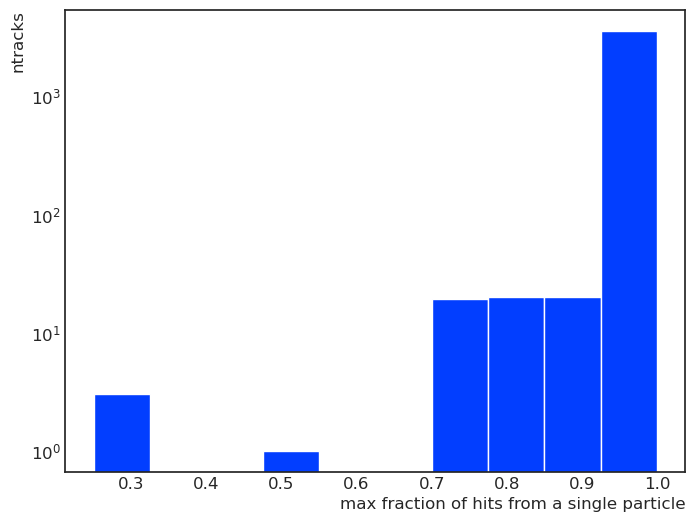

In [ ]:
n=plt.hist(df_traj[df_traj["total_count"]>3]["max_fraction"])
plt.yscale('log')
plt.xlabel("max fraction of hits from a single particle") 
plt.ylabel("ntracks")

##### efficiency


Text(0, 1, 'Ratio')

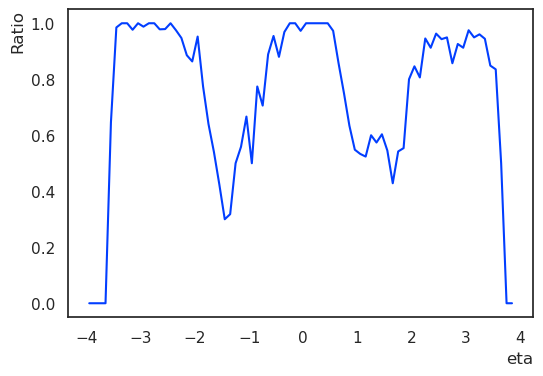

In [ ]:
bins = np.arange(-4, 4, 0.1)
eta_all = df_mc_good_sig["eta"]
eta_filtered = df_mc_good_sig[df_mc_good_sig.traj_id > -1]["eta"]

counts_all, bin_edges = np.histogram(eta_all, bins=bins)
counts_filtered, _ = np.histogram(eta_filtered, bins=bins)

ratio = counts_filtered / np.maximum(counts_all, 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.plot(bin_centers, ratio)
plt.xlabel('eta')
plt.ylabel('Ratio')

<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1605654/3229456415.py:17: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel("$\eta$")


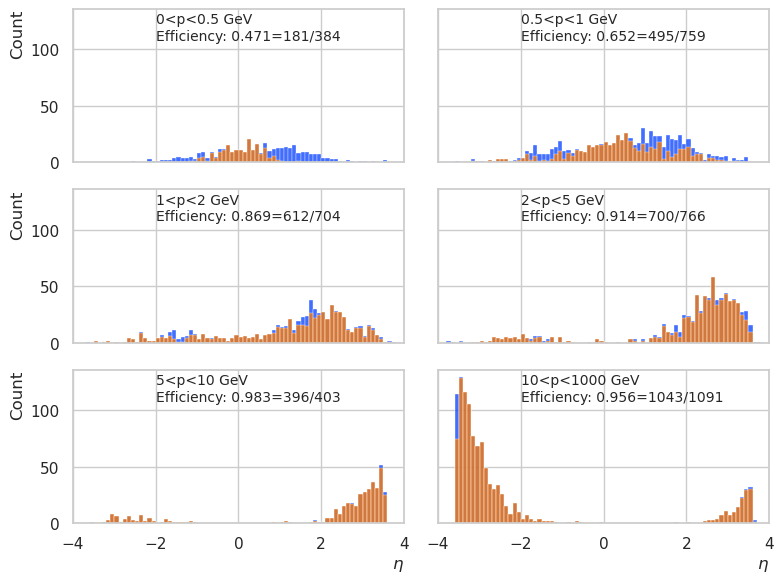

In [ ]:
## efficiency distribution
bins=np.arange(-4,4,0.1)
mom_bin=[0,0.5,1,2,5,10,1000]

fig,axes=plt.subplots(3,2,sharex=True, sharey=True, figsize=(8,6))
i = 0
for mom_min, mom_max in zip(mom_bin[:-1], mom_bin[1:]):
    ax = axes.flat[i]

    mom_cut = (df_mc_good_sig.mom>=mom_min)&(df_mc_good_sig.mom<mom_max)
    df = df_mc_good_sig[mom_cut]
    sns.histplot(df, x="eta", bins=bins,ax=ax)
    sns.histplot(df[df.traj_id>-1], x="eta", bins=bins, ax=ax)
    n1=len(df)
    n2=len(df[df.traj_id>-1])
    ax.text(0.25, 0.8, f"{mom_min}<p<{mom_max} GeV\nEfficiency: {n2/n1:.3f}={n2}/{n1} ", fontsize=10, transform=ax.transAxes)
    ax.set_xlim(-4,4)
    ax.set_xlabel(f"$\eta$")

    # ax2 = ax.twinx()
    # eta_all = df["eta"]
    # eta_filtered = df[df.traj_id > -1]["eta"]
    # counts_all, bin_edges = np.histogram(eta_all, bins=bins)
    # counts_filtered, _ = np.histogram(eta_filtered, bins=bins)
    # ratio = counts_filtered / np.maximum(counts_all, 1)
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # ax2.plot(bin_centers, ratio,lw=1,color='grey')
    # ax2.set_ylabel('Ratio', color='red')
    # ax2.set_ylim(0,2)
    # ax.grid('x')
    i=i+1
plt.tight_layout()

##### track purity


<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:33: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_118565/3056823826.py:33: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel(f"$\eta$")


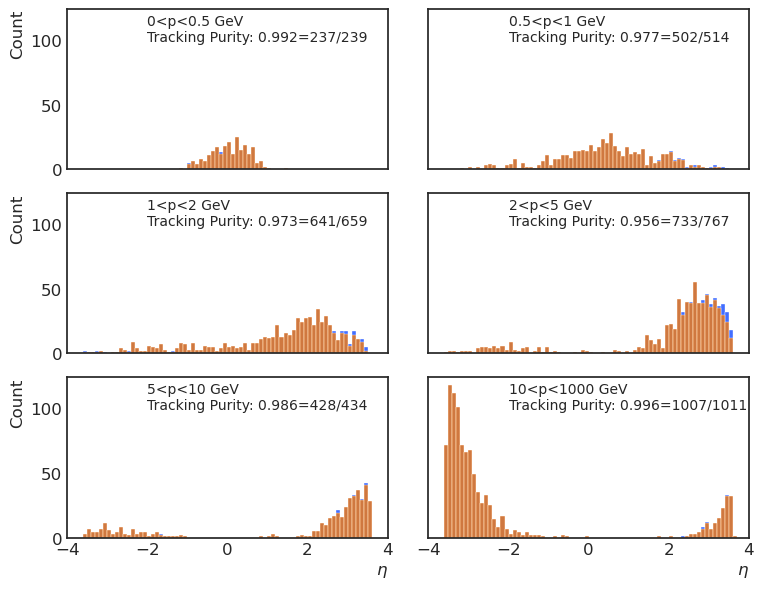

In [68]:
## purity distribution
bins=np.arange(-4,4,0.1)
mom_bin=[0,0.5,1,2,5,10,1000]
params=ak.to_dataframe(get_params(tree,"CentralCKFTrackParameters",entry_start=0,entry_stop=nevents))

fig,axes=plt.subplots(3,2,sharex=True, sharey=True, figsize=(8,6))
i = 0
valid_track = df_traj[df_traj.total_count>=track_hit_count_min].reset_index()
good_signal_track = valid_track[(valid_track.is_ghost==0)&((valid_track.part_status==1)|(valid_track.part_status==2))]

def df_select_entry_subentry(df,entry_list, subentry_list):
    pairs_df= pd.DataFrame({'entry':entry_list, 'subentry':subentry_list})
    return df.merge(pairs_df, on=['entry', 'subentry'])

valid_track_params=df_select_entry_subentry(params, valid_track["event"].values, valid_track["traj_id"].values)
good_signal_track_params=df_select_entry_subentry(params, good_signal_track["event"].values,good_signal_track["traj_id"].values)

for mom_min, mom_max in zip(mom_bin[:-1], mom_bin[1:]):
    ax = axes.flat[i]
    df = valid_track_params
    mom_cut = (df.mom>=mom_min)&(df.mom<mom_max)
    df = df[mom_cut]
    sns.histplot(df, x="eta", bins=bins,ax=ax)
    n1=len(df)

    df = good_signal_track_params
    mom_cut = (df.mom>=mom_min)&(df.mom<mom_max)
    df = df[mom_cut]
    sns.histplot(df, x="eta", bins=bins,ax=ax)#, fill=False)#, element='step',color='orange')
    n2=len(df)
    ax.text(0.25, 0.8, f"{mom_min}<p<{mom_max} GeV\nTracking Purity: {n2/n1:.3f}={n2}/{n1} ", fontsize=10, transform=ax.transAxes)
    ax.set_xlim(-4,4)
    ax.set_xlabel(f"$\eta$")

    # ax2 = ax.twinx()
    # eta_all = df["eta"]
    # eta_filtered = df[df.traj_id > -1]["eta"]
    # counts_all, bin_edges = np.histogram(eta_all, bins=bins)
    # counts_filtered, _ = np.histogram(eta_filtered, bins=bins)
    # ratio = counts_filtered / np.maximum(counts_all, 1)
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # ax2.plot(bin_centers, ratio,lw=1,color='grey')
    # ax2.set_ylabel('Ratio', color='red')
    # ax2.set_ylim(0,2)
    # ax.grid('x')
    i=i+1
plt.tight_layout()